# Extrinsic Calibration from 2D-2D Correspondences

### Goal

Given a set of 2D-2D correspondences between two camera images of known intrinsic parameters $K$, this notebook estimates their relative pose $R, t$.

* Input
  * $x_1$: 2D points in Cam1 image
  * $x_2$: 2D points in Cam2 image
  * $K_1$: Cam1 intrinsic parameter
  * $K_2$: Cam2 intrinsic parameter
* Output
  * $R, t$: Relative pose satisfying $X_2 = R X_1 + t$ (i.e., Cam1 is the world coordinate system)


Note:
1. If the two cameras share a single intrinsic parameter (e.g., structure-from-motion, or physically-identical cameras),
use `cv2.findEssentialMat()` and `cv2.recoverPose()`.


## Libraries

In [7]:
import sys, os, cv2
import numpy as np
from glob import glob
import matplotlib.pyplot as plt

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.insert(0,module_path)

from pycalib.plot import plotCamera
from pycalib.calib import lookat, skew, epipolar_distance

## Synthetic data

This cell defines a set of calibration parameters that satisfy

- world-to-camera: $c_i = R_i X + t_i$, and
- camera-to-image: $\lambda \hat{x}_i = K_i c_i$,

where $X$ is a 3D point in the world coodinate system, and $i = 1,2$.

In [8]:
# 3D points
# X_gt = (np.random.rand(16, 3) - 0.5)*5 + [0, 0, 10] # random points centered at [0, 0, 10]
X_gt = np.array(np.meshgrid(np.linspace(-2, 2, 5), np.linspace(-2, 2, 5), np.linspace(9, 11, 3))).reshape((3, -1)).T  # 3D grid points

# Camera poses
R1_gt = np.eye(3)
t1_gt = np.zeros(3).reshape((3,1))
R2_gt, t2_gt = lookat(np.array([1,0,0]), np.array([0,0,10]), np.array([0,1,0]))
rvec1_gt = cv2.Rodrigues(R1_gt)[0]
rvec2_gt = cv2.Rodrigues(R2_gt)[0]

# Camera intrinsics
K1 = np.array([[600, 0, 320], [0, 600, 240], [0, 0, 1]]).astype(np.float64)  # VGA camera
K2 = np.array([[800, 0, 640], [0, 800, 360], [0, 0, 1]]).astype(np.float64)  # 720p camera

# 2D corresponding points
x1 = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec1_gt, t1_gt, K1, None)[0].reshape((-1, 2))
x2 = cv2.projectPoints(X_gt.reshape((-1, 1, 3)), rvec2_gt, t2_gt, K2, None)[0].reshape((-1, 2))

# Verify triangulation
Y = cv2.triangulatePoints(K1 @ np.hstack((R1_gt, t1_gt)), K2 @ np.hstack((R2_gt, t2_gt)), x1.T, x2.T)
Y = Y[:3] / Y[3,:]
assert np.allclose(0, X_gt - Y.T)

# Verify z > 0 at each camera
assert np.all(X_gt[:, 2] > 0)
assert np.all((R2_gt @ X_gt.T + t2_gt)[2, :] > 0)

## Essential matrix

* Input: $K_1$, $K_2$, $x_1$, $x_2$
* Output: $E$ satisfying $ (K_2^{-1}\tilde{x}_2)^\top E (K_1^{-1} \tilde{x}_1) = 0$ 

In [17]:
# x1, x2 -> F
F, _ = cv2.findFundamentalMat(x1, x2, cv2.FM_8POINT)

x1h = cv2.convertPointsToHomogeneous(x1).reshape((-1,3)).T
x2h = cv2.convertPointsToHomogeneous(x2).reshape((-1,3)).T
n1 = np.linalg.inv(K1) @ x1h
n2 = np.linalg.inv(K2) @ x2h

# check F error
F_err = x2h.T @ F @ x1h
F_err = np.mean(F_err**2)
print(f'x2.T@F@x1 error (F[2,2]==1) = {F_err}')

# F, K1, K2 -> E
# x2.T F x1 = 0 <-> n2.T E n1 = 0 where n1 = K1^-1 x1
E = K2.T @ F @ K1
E = E / np.linalg.norm(E)

# check E error
E_err = np.mean((n2.T @ E @ n1)**2)
print(f'n2.T@E@n1 error = {E_err}')

# Theoretically, F error and E error must be identical.
# However, due to the scaling of E and F, they can be different.
# Since the normalization factor for E depends on K1 and K2,
# we cannot scale F so as to return the identical error without knowing K1 and K2.
F2 = np.linalg.inv(K2).T @ E @ np.linalg.inv(K1)
F_err2 = np.mean((x2h.T @ F2 @ x1h)**2)
print(f'x2.T@F@x1 error (normalized) = {F_err2}')

# To verify that F and F2 are identical, see the epipolar distance
print(f'Epipolar distance (F[2,2]=1) = {np.mean(epipolar_distance(x1h.T, x2h.T, F)**2)}')
print(f'Epipolar distance (normalized) = {np.mean(epipolar_distance(x1h.T, x2h.T, F2)**2)}')


x2.T@F@x1 error (F[2,2]==1) = 5.752666408363835
n2.T@E@n1 error = 0.02021163177776471
x2.T@F@x1 error (normalized) = 0.02021163177776471
Epipolar distance (F[2,2]=1) = 3.400642677405484e-11
Epipolar distance (normalized) = 3.4006426781101624e-11


## Decompose $R, t$ from $E$

Given an essentinal matrix $E$, we have four possible solutions
* $R, t$,
* $R, -t$,
* $R', t$, and
* $R', -t$.

We can find the collect one by checking if the triangulated 3D points appear in front of the both cameras.



In [10]:
R2a, R2b, t2 = cv2.decomposeEssentialMat(E)
R1 = np.eye(3)
t1 = np.zeros((3,1))

def z_count(R1, t1, R2, t2, K1, K2, x1, x2):
    """
    Count number of points appeared in front of the cameras
    """
    P1 = K1 @ np.hstack((R1, t1))
    P2 = K2 @ np.hstack((R2, t2))
    Xh1 = cv2.triangulatePoints(P1, P2, x1, x2)
    Xh1 /= Xh1[3,:]
    z1 = np.sum(Xh1[2,:]>0)  # num of positive z points in Cam1 coordinate system
    Xh2 = R2 @ Xh1[:3,:] + t2
    z2 = np.sum(Xh2[2,:]>0)  # num of positive z points in Cam2 coordinate system
    return (z1 + z2), Xh1[:3,:]

zmax = -1
for R2x, t2x in [[R2a, t2], [R2a, -t2], [R2b, t2], [R2b, -t2]]:
    z, Xx = z_count(R1, t1, R2x,  t2x, K1, K2, x1.T, x2.T)
    if zmax < z:
        zmax = z
        R2_est = R2x
        t2_est = t2x
        X_est = Xx


print('R2 = ', R2_est)
print('t2 = ', t2_est)

print('R2_gt = ', R2_gt)  # ground truth
print('t2_gt = ', t2_gt)  # ground truth

assert np.allclose(R2_est, R2_gt, atol=1e-5)
assert np.allclose(t2_est, t2_gt, atol=1e-5)

R2 =  [[ 9.95037176e-01 -7.13823988e-09  9.95038597e-02]
 [ 1.66459061e-08  1.00000000e+00 -9.47205016e-08]
 [-9.95038597e-02  9.59067526e-08  9.95037176e-01]]
t2 =  [[-9.95036933e-01]
 [-1.89915470e-07]
 [ 9.95062893e-02]]
R2_gt =  [[ 0.99503719 -0.          0.09950372]
 [ 0.          1.          0.        ]
 [-0.09950372  0.          0.99503719]]
t2_gt =  [[-0.99503719]
 [ 0.        ]
 [ 0.09950372]]


## Plot

/tmp/ipykernel_30765/2310628978.py:12: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


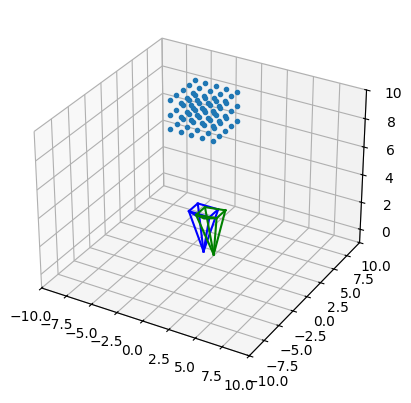

In [11]:
fig = plt.figure()
ax = fig.add_subplot(projection='3d')

ax.set_xlim(-10, 10)
ax.set_ylim(-10, 10)
ax.set_zlim(-1, 10)

plotCamera(ax, R1, t1, color="b", scale=1)
plotCamera(ax, R2_est.T, - R2_est.T @ t2_est, color="g", scale=1)
ax.plot(X_est[0,:], X_est[1,:], X_est[2,:], ".")

fig.show()

## $K, R, t \rightarrow E, F$

In this example, we first computed $F$ from the 2D correspondences, converted $F$ to $E$, and decomposed $E$ into $R, t$.  Inversely, let's build $E$ and $F$ directly from the ground-truth $R_1, t_1$ and $R_2, t_2$.

$E$ satisfying $ (K_2^{-1}\tilde{x}_2)^\top E (K_1^{-1} \tilde{x}_1) = 0$ is defined as

$$ E = [t_{12}]_\times R_{12}\,, $$

where $R_{12}$ and $t_{12}$ transforms 3D points in the camera 1 coordinate system to the camera 2 coordinate system. That is, they satisfy $c_2 = R_{12} c_1 + t_{12}$. So the first step is to build $R_{12}$ and $t_{12}$ from $R_1, t_1$ and $R_2, t_2$. Given $c_i = R_i X + t_i$, we have

$$ c_2 = R_2 \left(R_1^\top (c_1 - t_1) \right) + t_2 = (R_2 R_1^\top) c_1 + (t_2 - R_2 R_1^\top t_1 ) = R_{12} c_1 + t_{12} \,,$$

where $R_{12} = R_2 R_1^\top$ and $t_{12} = t_2 - R_2 R_1^\top t_1$.

In [12]:
# get R12, t12 which satisfies c2 = R12 @ c1 + t12
R12 = R2_gt @ R1_gt.T
t12 = t2_gt - R12 @ t1_gt

# get E
E21 = skew(t12) @ R12
E21 = E21 / np.linalg.norm(E21)

# check E error
E21_err = np.mean((n2.T @ E21 @ n1)**2)
print(f'E error = {E21_err}')
assert np.allclose(E_err, E21_err)

# get F
F21 = np.linalg.inv(K2).T @ E21 @ np.linalg.inv(K1)

# check F error
F21_err = x2h.T @ F21 @ x1h
F21_err = np.mean(F21_err**2)
print(f'F error = {F21_err}')   # should be identical to E_err
assert np.allclose(E_err, F21_err)



E error = 0.020211636822355675
F error = 0.020211636822355668


## Exercises

1. Add Gaussian noise (e.g. $\mu=0, \sigma=1 \mathrm{px}$) to the 2D observations `x1` and `x2`, and see how the results are degraded.
2. Add outliers to `x1` and `x2`.
3. Introduce distortion correction.
   * Assume distorted observations and distortion coefficients are given.  Rectify the observations as a preprocessing.